# The Battle of the Neighborhoods

## Coursera Capstone - IBM Data Science Specialization

#### Authored By: Padhma M

## Contents
1. Introduction 
2. Data Preparation
3. Methodology
4. Results

## Business Problem

Our customer is ABC Bank, which is an International Bank and also a market leader. They have a  wide variety of customers all over the country, major of them residing in Metropolitan cities. ABC Bank has received ample amounts of complaints from residents of Bangalore that there aren’t sufficient amount of ATM’s. Given the extremely large population and the population of the city, our customer wants to identify the best neighborhood area to open more ATM covering the majority of the population. The problem statement will be: **Which neighborhood is most densely populated and has lesser number of ATM’s?**

## Data Preparation

Importing necesary libraries

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
# get latitude and longitude using geopy library
from geopy.geocoders import Nominatim
import requests 
from pandas.io.json import json_normalize
# import k-means from clustering stage
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
print('Libraries imported!')

Libraries imported!


### The data is not readily available. Hence, Scraping from wiki page using Beautifulsoup.

In [2]:
source_page = requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Bangalore').text
soup = BeautifulSoup(source_page,'lxml')

In [3]:
neigh = []
areas = []
locality = ['Central','Eastern','North Eastern','Northern','South Eastern','Southern','Southern suburbs','Western']
for k in range(len(locality)):
    table = soup.find_all('table')[k]
    table_data = table.find_all('td')
    col_len = len(table_data)

    for i in range(0,col_len,3):
        neigh.append(table_data[i].text.strip())
        areas.append(locality[k])

In [4]:
df_neigh = pd.DataFrame(data=[neigh,areas])
df_neigh = df_neigh.transpose()
df_neigh.columns = ['Neighbourhood','Area']
df_neigh.head()

,Neighbourhood,Area
0,Cantonment area,Central
1,Domlur,Central
2,Indiranagar,Central
3,Jeevanbheemanagar,Central
4,Malleswaram,Central


### Obtaining the Coordinates for each Neighborhood using Geopy

In [5]:
address = 'Bangalore'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat = location.latitude
long = location.longitude
print('The geograpical coordinate of Bangalore are {}, {}.'.format(lat, long))

The geograpical coordinate of Bangalore are 12.9791198, 77.5912997.


In [6]:
neighborhoods = df_neigh['Neighbourhood'].unique().tolist()
neighborhoods

['Cantonment area',
 'Domlur',
 'Indiranagar',
 'Jeevanbheemanagar',
 'Malleswaram',
 'Pete area',
 'Sadashivanagar',
 'Seshadripuram',
 'Shivajinagar',
 'Ulsoor',
 'Vasanth Nagar',
 'Bellandur',
 'CV Raman Nagar',
 'Hoodi',
 'Krishnarajapuram',
 'Mahadevapura',
 'Marathahalli',
 'Varthur',
 'Whitefield',
 'Banaswadi',
 'HBR Layout',
 'Horamavu',
 'Kalyan Nagar',
 'Kammanahalli',
 'Lingarajapuram',
 'Ramamurthy Nagar',
 'Hebbal',
 'Jalahalli',
 'Mathikere',
 'Peenya',
 'R. T. Nagar',
 'Vidyaranyapura',
 'Yelahanka',
 'Yeshwanthpur',
 'Bommanahalli',
 'Bommasandra',
 'BTM Layout',
 'Electronic City',
 'HSR Layout',
 'Koramangala',
 'Madiwala',
 'Banashankari',
 'Basavanagudi',
 'Girinagar',
 'J. P. Nagar',
 'Jayanagar',
 'Kumaraswamy Layout',
 'Padmanabhanagar',
 'Uttarahalli',
 'Anjanapura',
 'Arekere',
 'Begur',
 'Gottigere',
 'Hulimavu',
 'Kothnur',
 'Basaveshwaranagar',
 'Kamakshipalya',
 'Kengeri',
 'Mahalakshmi Layout',
 'Nagarbhavi',
 'Nandini Layout',
 'Nayandahalli',
 'Rajajina

In [7]:
address = neighborhoods
latitude = []
longitude = []

for i in range(len(neighborhoods)):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address[i])
    if location:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    else:
        latitude.append(None)
        longitude.append(None)
#         print('The geograpical coordinate of {} are {}, {}.'.format(address[i],latitude, longitude))

In [8]:
df_new = pd.DataFrame()
df_new['Neighborhood'] = neighborhoods
df_new['Region'] = areas
df_new['Latitude'] = latitude
df_new['Longitude'] = longitude
df_new.head(3)

,Neighborhood,Region,Latitude,Longitude
0,Cantonment area,Central,8.468109,-13.250525
1,Domlur,Central,12.962467,77.638196
2,Indiranagar,Central,17.756964,77.188905


In [9]:
df_new.shape

(65, 4)

### Finding columns with null values and replacing them

In [10]:
null_columns=df_new.columns[df_new.isnull().any()]
print(df_new[df_new.isnull().any(axis=1)][null_columns])

   Latitude  Longitude
3       NaN        NaN


In [11]:
df_new.loc[df_new['Neighborhood'] == 'Jeevanbheemanagar','Latitude'] = 12.968926
df_new.loc[df_new['Neighborhood'] == 'Jeevanbheemanagar','Longitude'] = 77.652705

In [13]:
# number of neighborhoods and regions in the city
print('The number of neighborhoods in Bangalore is: {}'.format(df_new['Neighborhood'].nunique()))
print('The number of regions in Bangalore is: {}'.format(df_new['Region'].nunique()))

The number of neighborhoods in Bangalore is: 65
The number of regions in Bangalore is: 8


Visualize the neighborhoods using folium map

In [14]:
map_bang = folium.Map(location=[lat, long], zoom_start=11)

# add markers to map
for lati, lng, region, neighborhood in zip(df_new['Latitude'], 
                                           df_new['Longitude'], 
                                           df_new['Region'], 
                                           df_new['Neighborhood']):
    label = '{} - {}'.format(neighborhood,region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bang)  
    
map_bang

## Methodology

FourSquare Credentials and version

In [15]:
LIMIT = 100
radius = 500
CLIENT_ID = 'XXXXX' 
CLIENT_SECRET = 'XXXXX'
VERSION = '20180605' 

Function to get nearby venues using foursquare

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
bangalore_venues = getNearbyVenues(names=df_new['Neighborhood'],
                                   latitudes=df_new['Latitude'],
                                   longitudes=df_new['Longitude']
                                  )

Cantonment area
Domlur
Indiranagar
Jeevanbheemanagar
Malleswaram
Pete area
Sadashivanagar
Seshadripuram
Shivajinagar
Ulsoor
Vasanth Nagar
Bellandur
CV Raman Nagar
Hoodi
Krishnarajapuram
Mahadevapura
Marathahalli
Varthur
Whitefield
Banaswadi
HBR Layout
Horamavu
Kalyan Nagar
Kammanahalli
Lingarajapuram
Ramamurthy Nagar
Hebbal
Jalahalli
Mathikere
Peenya
R. T. Nagar
Vidyaranyapura
Yelahanka
Yeshwanthpur
Bommanahalli
Bommasandra
BTM Layout
Electronic City
HSR Layout
Koramangala
Madiwala
Banashankari
Basavanagudi
Girinagar
J. P. Nagar
Jayanagar
Kumaraswamy Layout
Padmanabhanagar
Uttarahalli
Anjanapura
Arekere
Begur
Gottigere
Hulimavu
Kothnur
Basaveshwaranagar
Kamakshipalya
Kengeri
Mahalakshmi Layout
Nagarbhavi
Nandini Layout
Nayandahalli
Rajajinagar
Rajarajeshwari Nagar
Vijayanagar


Finding total number of venues

In [18]:
print('There are {} uniques categories.'.format(len(bangalore_venues['Venue Category'].unique())))

There are 145 uniques categories.


Finding the count of each venue in each neighborhood

In [19]:
bangalore_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Anjanapura,1,1,1,1,1,1
Arekere,31,31,31,31,31,31
BTM Layout,33,33,33,33,33,33
Banashankari,6,6,6,6,6,6
Banaswadi,9,9,9,9,9,9
Basavanagudi,16,16,16,16,16,16
Basaveshwaranagar,12,12,12,12,12,12
Begur,4,4,4,4,4,4
Bommanahalli,3,3,3,3,3,3


Analyse each neighborhood

In [20]:
# one hot encoding
bang_onehot = pd.get_dummies(bangalore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bang_onehot['Neighborhood'] = bangalore_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bang_onehot.columns[-1]] + list(bang_onehot.columns[:-1])
bang_onehot = bang_onehot[fixed_columns]

bang_onehot.head()

,Yoga Studio,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Tea Room,Thai Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Lets find the shape of the resulting dataframe

In [21]:
bang_onehot.shape

(789, 145)

Group rows by neighborhood

In [22]:
bangalore_grouped = bang_onehot.groupby('Neighborhood').mean().reset_index()
bangalore_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Tea Room,Thai Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store
0,Anjanapura,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Arekere,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.032258,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,BTM Layout,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.060606,0.000000,0.000000
3,Banashankari,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Banaswadi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000
5,Basavanagudi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Basaveshwaranagar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Begur,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Bommanahalli,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,CV Raman Nagar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Obtain top 5 venues in each neighborhood

In [23]:
num_top_venues = 5

for hood in bangalore_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bangalore_grouped[bangalore_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Anjanapura----
                      venue  freq
0                      Pool   1.0
1               Yoga Studio   0.0
2           Motorcycle Shop   0.0
3                    Market   0.0
4  Mediterranean Restaurant   0.0


----Arekere----
                 venue  freq
0    Indian Restaurant  0.13
1  Sporting Goods Shop  0.13
2       Ice Cream Shop  0.10
3     Department Store  0.06
4         Burger Joint  0.06


----BTM Layout----
                venue  freq
0   Indian Restaurant  0.18
1      Ice Cream Shop  0.09
2         Snack Place  0.09
3  Chinese Restaurant  0.09
4              Bakery  0.09


----Banashankari----
                venue  freq
0   Indian Restaurant  0.33
1                Café  0.33
2      Clothing Store  0.17
3         Pizza Place  0.17
4  Mughlai Restaurant  0.00


----Banaswadi----
                           venue  freq
0  Vegetarian / Vegan Restaurant  0.22
1              Indian Restaurant  0.22
2                      BBQ Joint  0.11
3                       Pharm

Function to sort venues in descending order

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a dataframe and store the top 5 most common venues

In [25]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_grouped['Neighborhood']

for ind in np.arange(bangalore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Anjanapura,Pool,Women's Store,Department Store,Eastern European Restaurant,Donut Shop
1,Arekere,Sporting Goods Shop,Indian Restaurant,Ice Cream Shop,Chinese Restaurant,Burger Joint
2,BTM Layout,Indian Restaurant,Chinese Restaurant,Snack Place,Ice Cream Shop,Bakery
3,Banashankari,Café,Indian Restaurant,Clothing Store,Pizza Place,Women's Store
4,Banaswadi,Indian Restaurant,Vegetarian / Vegan Restaurant,Pharmacy,Juice Bar,BBQ Joint
5,Basavanagudi,Indian Restaurant,Sandwich Place,Fast Food Restaurant,Restaurant,Juice Bar
6,Basaveshwaranagar,Fast Food Restaurant,Indian Restaurant,Ice Cream Shop,Juice Bar,Snack Place
7,Begur,Supermarket,ATM,Clothing Store,Bakery,Women's Store
8,Bommanahalli,Indian Restaurant,Department Store,Women's Store,Eastern European Restaurant,Donut Shop
9,CV Raman Nagar,Indian Restaurant,Bakery,Smoke Shop,Café,Coffee Shop


## Clustering

Creating five clusters of the neighborhood

In [26]:
# set number of clusters
kclusters = 5

bangalore_grouped_clustering = bangalore_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 4, 4, 0, 4, 0, 4, 4, 0, 0], dtype=int32)

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
bangalore_merged = df_new

# merge bangalore_grouped with df_new to add latitude/longitude for each neighborhood
bangalore_merged = bangalore_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Ignore any Nan values in the DataFrame

In [28]:
bangalore_merged = bangalore_merged[np.isfinite(bangalore_merged['Cluster Labels'])]
bangalore_merged['Cluster Labels'] = bangalore_merged['Cluster Labels'].astype(int)

Create a map of the clusters

In [29]:
# create map
map_clusters = folium.Map(location=[lat, long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bangalore_merged['Latitude'], bangalore_merged['Longitude'], bangalore_merged['Neighborhood'], bangalore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 0

In [30]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 0, bangalore_merged.columns[[0] + list(range(5, bangalore_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Cantonment area,Music Venue,Café,Bakery,Indian Restaurant,Event Space
3,Jeevanbheemanagar,Indian Restaurant,Chinese Restaurant,Café,Dessert Shop,Kerala Restaurant
8,Shivajinagar,Indian Restaurant,Hotel,Jewelry Store,Bus Station,Market
9,Ulsoor,Indian Restaurant,Hotel,Restaurant,Light Rail Station,Dessert Shop
10,Vasanth Nagar,Indian Restaurant,Hotel,Nightclub,Coffee Shop,Japanese Restaurant
12,CV Raman Nagar,Indian Restaurant,Bakery,Smoke Shop,Café,Coffee Shop
13,Hoodi,Indian Restaurant,Furniture / Home Store,Bus Station,Women's Store,Eastern European Restaurant
14,Krishnarajapuram,Bakery,Hotel,Tibetan Restaurant,Indian Restaurant,Women's Store
15,Mahadevapura,Indian Restaurant,Convenience Store,Bus Station,Shopping Mall,Department Store
16,Marathahalli,Indian Restaurant,Clothing Store,Vegetarian / Vegan Restaurant,Ice Cream Shop,Shoe Store


### Cluster 1

In [31]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 1, bangalore_merged.columns[[0] + list(range(5, bangalore_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Pete area,Department Store,Multiplex,Shopping Mall,Women's Store,Eastern European Restaurant
17,Varthur,Department Store,Vietnamese Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


### Cluster 2

In [32]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 2, bangalore_merged.columns[[0] + list(range(5, bangalore_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
49,Anjanapura,Pool,Women's Store,Department Store,Eastern European Restaurant,Donut Shop


### Cluster 3

In [33]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 3, bangalore_merged.columns[[0] + list(range(5, bangalore_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,Peenya,Light Rail Station,Fast Food Restaurant,Coffee Shop,Dessert Shop,Eastern European Restaurant


### Cluster 4

In [34]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 4, bangalore_merged.columns[[0] + list(range(5, bangalore_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Domlur,Indian Restaurant,Café,Chinese Restaurant,Sports Bar,Sandwich Place
2,Indiranagar,Indian Restaurant,Café,Pub,Vegetarian / Vegan Restaurant,Pizza Place
4,Malleswaram,Ice Cream Shop,Indian Restaurant,South Indian Restaurant,Coffee Shop,Donut Shop
6,Sadashivanagar,Coffee Shop,Café,Department Store,Seafood Restaurant,Gourmet Shop
7,Seshadripuram,Ice Cream Shop,Indian Restaurant,Fast Food Restaurant,Chaat Place,Chinese Restaurant
18,Whitefield,Bakery,Gym / Fitness Center,Grocery Store,Hotel,Hotel Bar
19,Banaswadi,Indian Restaurant,Vegetarian / Vegan Restaurant,Pharmacy,Juice Bar,BBQ Joint
20,HBR Layout,Indian Restaurant,Café,Snack Place,Gym / Fitness Center,Kebab Restaurant
22,Kalyan Nagar,Café,Korean Restaurant,Ice Cream Shop,BBQ Joint,Indian Restaurant
23,Kammanahalli,Pizza Place,Restaurant,Women's Store,Department Store,Donut Shop


### Count of neighborhoods in each cluster

In [35]:
bangalore_merged.groupby('Cluster Labels').count()['Neighborhood']

Cluster Labels
0    23
1     2
2     1
3     1
4    33
Name: Neighborhood, dtype: int64

Obtain the Neighborhood data

In [36]:
df_reg = pd.read_csv('Bangalore neighborhoods.csv')
df_reg.head()

,Neighborhood,Region,Latitude,Longitude
0,Cantonment area,Central,12.995441,77.601429
1,Domlur,Central,12.962467,77.638196
2,Indiranagar,Central,12.979441,77.641689
3,Jeevanbheemanagar,Central,12.968926,77.652705
4,Malleswaram,Central,13.006163,77.567158


Obtain the Population data

In [37]:
df_pop = pd.read_csv('Bangalore populations.csv')
df_pop.head()

,Neighborhood,Population
0,Cantonment area,157683
1,Domlur,69406
2,Indiranagar,85890
3,Jeevanbheemanagar,76502
4,Malleswaram,60697


Merge the population data with the neighborhood data

In [38]:
df_bang = df_reg.merge(df_pop,on='Neighborhood')
df_bang.head()

,Neighborhood,Region,Latitude,Longitude,Population
0,Cantonment area,Central,12.995441,77.601429,157683
1,Domlur,Central,12.962467,77.638196,69406
2,Indiranagar,Central,12.979441,77.641689,85890
3,Jeevanbheemanagar,Central,12.968926,77.652705,76502
4,Malleswaram,Central,13.006163,77.567158,60697


sorting the neighborhoods based on population

In [39]:
df_sorted = df_bang.sort_values(by='Population', ascending=False, inplace=False)

In [40]:
df_top = df_sorted.head(15)
df_top = df_top.reset_index(drop=True)
df_top

,Neighborhood,Region,Latitude,Longitude,Population
0,Mahalakshmi Layout,Western,13.011894,77.543858,586460
1,Hulimavu,Southern suburbs,12.873457,77.598534,500006
2,Bommanahalli,South Eastern,12.902924,77.622897,224980
3,Horamavu,North Eastern,13.027331,77.660151,196553
4,Electronic City,South Eastern,12.848292,77.674371,186234
5,Krishnarajapuram,Eastern,13.016118,77.703510,186210
6,Cantonment area,Central,12.995441,77.601429,157683
7,Mahadevapura,Eastern,12.988679,77.688249,154223
8,Banashankari,Southern,12.925932,77.545919,150000
9,Hebbal,Northern,13.038218,77.591900,132571


Convert the population column to percentage

In [41]:
df_top['Population'] = (100. * df_top['Population'] / df_top['Population'].sum() ).round(2)

In [42]:
df_top.rename(columns={'Population':'Population %'},inplace=True)
df_top = df_top.drop(columns=['Region','Latitude','Longitude'])
df_top

,Neighborhood,Population %
0,Mahalakshmi Layout,19.75
1,Hulimavu,16.84
2,Bommanahalli,7.58
3,Horamavu,6.62
4,Electronic City,6.27
5,Krishnarajapuram,6.27
6,Cantonment area,5.31
7,Mahadevapura,5.19
8,Banashankari,5.05
9,Hebbal,4.47


Visualize the data in a bar plot to obtain better insights

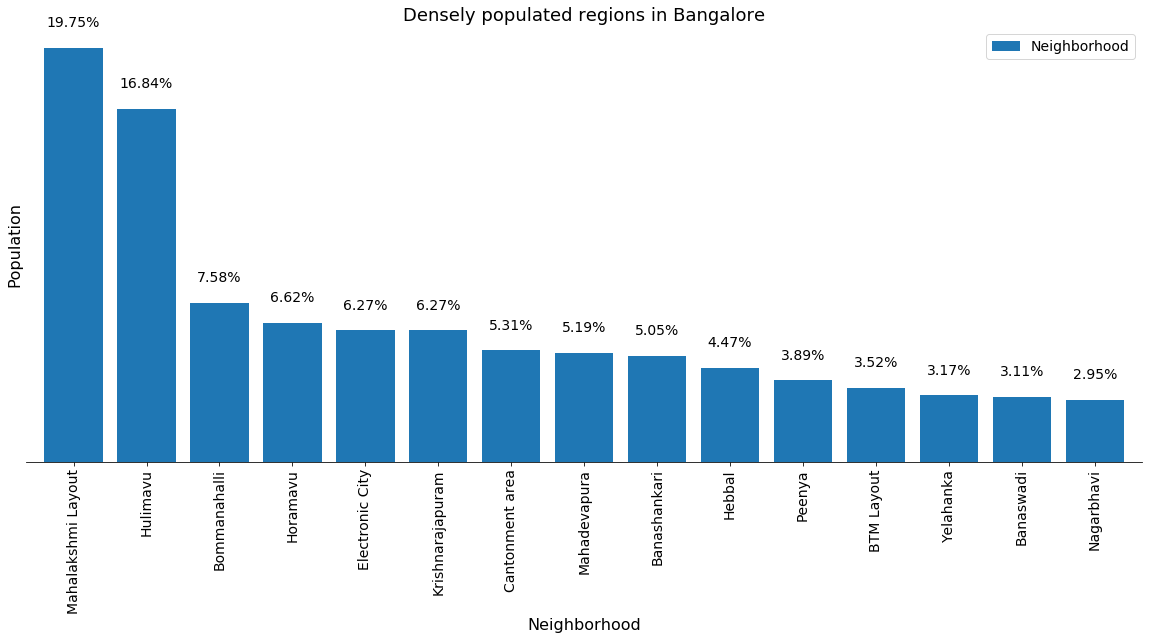

In [43]:
ax = df_top.plot(x='Neighborhood' ,kind='bar', figsize=(20,8), width=0.8, edgecolor=None, fontsize=20)

ax.legend(labels=df_top.columns, fontsize=14)
ax.set_title('Densely populated regions in Bangalore', fontsize=18) # add title to the plot
ax.set_xlabel('Neighborhood', fontsize=16) # add to x-label to the plot
ax.set_ylabel('Population', fontsize=16) # add y-label to the plot

# ax.tick_params(fontsize=10)
plt.yticks([])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=14)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    h = height/100
    x, y = p.get_xy() 
    ax.annotate('{:.2%}'.format(h), (p.get_x()+.5*width, p.get_y() + height + 1), ha = 'center',fontsize=14)

plt.show()

### Results

By the population graph and the cluster map, we see that the first cluster contains most of the populous neighborhoods. Hence, by placing more ATM machine’s in the first cluster’s neighborhoods, the needs of the customers will be successfully met and the complaints will reduce drastically. 

During this work, some of the machine learning techniques, data wrangling with pandas and data visualization techniques were put to use. 